# QOSF - Task 1

Implement, on a quantum simulator of your choice, the following 4 qubits state |()>:
Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:


Even blocks


Odd blocks


The angles i, nare variational parameters, lying in the interval (0, 2), initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$\varepsilon = \min_{\theta} || |\psi(\theta)> - |\phi> ||$

Where |$\phi$> is a randomly generated vector on 4 qubits and the norm || |v> ||, of a state |v>, simply denotes the sum of the squares of the components of |v>. The right set of parameters i,n can be found via any method of choice (e.g. grid-search or gradient descent)


---

### Bonus question:
Try using other gates for the parametrized gates and see what happens.


# TODO
- [x] Ensure initial random vector is the same for all optimizers, just to be fair
- [ ] Tests
- [x] Write docs and references
- [-] Optimize optimizer parameters, eta's, tolerances, etc.
- [x] Run it once with 1000 iterations, and go for lunch, and hope jupyter doesn't die
- [x] Benchmark execution time for each optimizer
- [ ] Compare with a solution on the DWave annealer
- [x] Add a noise model to the simulator and reevaluate results
- [x] Bonus question

## Environment setup

In [1]:
#pip3 install qiskit, numpy, matplotlib

import qiskit
import numpy as np
import time
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, QuantumCircuit, execute, quantum_info
from qiskit.providers.aer.noise import NoiseModel
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

## Approach
We will use the defined "odd" and "even" gates in steps defined by "Layers". With Rx gates for the odd blocks, and Rz's and full entanglement for the even blocks.

All gates in each block have the same theta rotation, therefore the variational parameters will be 2*Layers. (One for the odd and one for the even blocks).

We will first create the circuit in a way that we can call it individually from a cost function. We will first use a random parameter algorithm to have a benchmark, an compare with COBYLA, SPSA and AQBD. In further iterations we can try optimizing the hyperparameters of each optimizer and add other algorithms.

## Initial constants

#### Stuff you can change
L = Layers, or iterations of odd / even unitary gates

N_QUBITS = Number of Qubits for the unitary gates

ITERATIONS =  Number of iterations for each optimizer. The more, the merrier, and the hotter your CPU


Block to configure the rotations and entanglers. Possible values are RX, RZ and RY for rotations and CX and CZ for entanglers

ODD_GATES_ROTATION = "RX"

EVEN_GATES_ROTATION = "RZ"

EVEN_GATES_ENTANGLER = "CZ"



#### Better not change this
CURRENT_LAYER = Constant to update the layers for each iteration

PHI = Target vector, initialited randomly for comparison

THETAS = Random initial Thetas. Array for all possible values depending on the number of layers. We calculate all Thetas at the beginning to ensure all optimiers AND layers start with the same random vector. Same with Phi. (Let's be fair!)

CALCULATiON_TIMES = Just a list to store the execution times for each optimizer to compare later on


In [2]:
def calculate_random_theta():
    return np.random.uniform(0, 2*np.pi)

def get_random_thetas(layers):
    thetas = []
    for i in range(layers):
        thetas.append(calculate_random_theta())
    return thetas

In [26]:
L = 20
N_QUBITS = 4
ITERATIONS = 500 # Iterations for each step in each opimizer. Start with 50 to test. Then increase gradually and go for a (long) coffee

ODD_GATES_ROTATION = "RX"
EVEN_GATES_ROTATION = "RZ"
EVEN_GATES_ENTANGLER = "CZ"

CURRENT_LAYER = 0
PHI = quantum_info.random_statevector(2**N_QUBITS)
# Calculate ALL Thetas at the beginning so we can use the same random initial vector for all optimizers
for i in range(L):
    THETAS = get_random_thetas(L * 2)

CALCULATION_TIMES = {}
backend = Aer.get_backend("qasm_simulator")

### Preparing the Circuit
Adding functions to create unitary gates, calculate random theta angles for each layers and finally create and run the variational circuit.

We use the statevetor simulator to compare with the initial random phi. And create the objective (cost) function to minimize using the norm between psi(theta) and phi.

In [4]:
# Unitary 4 Qubit gate with Rz's full entanglement
def even_gate(theta, index, qubits):
    name = "Ue"+str(index)+"("+str(theta)+")"
    u_even = QuantumCircuit(len(qubits), name=name)
    
    if(EVEN_GATES_ROTATION == "RZ"):
        u_even.rz(theta,qubits)
    elif(EVEN_GATES_ROTATION == "RY"):
        u_even.ry(theta,qubits)
    else:
        u_even.rx(theta,qubits)

    for t in qubits:
        i = t
        for z in range(len(qubits)-t-1):
            if(EVEN_GATES_ENTANGLER == "cz"):
                u_even.cz(t, i + 1)
            elif(EVEN_GATES_ROTATION == "cy"):
                u_even.cy(t, i + 1)
            else:
                u_even.cx(t, i + 1)
            i += 1

    return u_even

# Unitary 4 Qubit gate with Rx's and no entanglement
def odd_gate(theta, index, qubits):
    name = "Uo"+str(index)+"("+str(theta)+")"
    u_odd = QuantumCircuit(len(qubits), name=name)
    if(ODD_GATES_ROTATION == "RZ"):
        u_odd.rz(theta,qubits)
    elif(ODD_GATES_ROTATION == "RY"):
        u_odd.ry(theta,qubits)
    else:
        u_odd.rx(theta,qubits)

    return u_odd

In [5]:
def get_variational_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    
    qubits = [i for i in range(n_qubits)]
    circuit = QuantumCircuit(n_qubits)
    theta = 0
    for i in range(layers):
        circuit.append(even_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        circuit.append(odd_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        
    return circuit

def run_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    circuit = get_variational_circuit(thetas)
    
    simulator = Aer.get_backend("statevector_simulator")
    job = execute(circuit, backend=simulator, shots=1024, noise_model=noise_model)
    result = job.result()
    
    return result.get_statevector(circuit)

def objective_function(thetas):
    psi_theta = run_circuit(thetas)
    cost = np.linalg.norm(psi_theta - PHI.data)
    return cost

In [6]:
# Test the Circuit to make sure everything is ok, and thetas are properly applied
CURRENT_LAYER = 2
circuit = get_variational_circuit(THETAS)
circuit.draw()

┌────────────────────────┐┌─────────────────────────┐»
q_0: ┤0                       ├┤0                        ├»
     │                        ││                         │»
q_1: ┤1                       ├┤1                        ├»
     │  Ue0(5.37906609062041) ││  Uo0(4.619632828581016) │»
q_2: ┤2                       ├┤2                        ├»
     │                        ││                         │»
q_3: ┤3                       ├┤3                        ├»
     └────────────────────────┘└─────────────────────────┘»
«     ┌──────────────────────────┐┌──────────────────────────┐
«q_0: ┤0                         ├┤0                         ├
«     │                          ││                          │
«q_1: ┤1                         ├┤1                         ├
«     │  Ue1(3.0995654074013728) ││  Uo1(0.9940908153706061) │
«q_2: ┤2                         ├┤2                         ├
«     │                          ││                          │
«q_3: ┤3                         ├┤3                         ├
«     └──────────────────────────┘└──────────────────────────┘

## Adding Noise
VQE Circuits tend to be useful in noisy quantum computers in the NISQ era. To simulate that fact we will add the noise from the actual computer we would use in real life: IBMQ_Santiago, with 5 Qubits and a Quantum Volume of 32.

We could add individual noise levels for the gates used, but in order to simplify the circuit we will just use the real ones from IBM

In [7]:
# Get Noise levels from Melbourne Q Computer
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(backend)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


### Getting results

1. Random Thetas (MonteCarlo sampling)
2. COBYLA
3. SPSA
4. AQGD

Results are stored in a specific list so we can plot and compare them later. 
Optimization methods have been chosen from common VQE tutorials and playgrounds (specially SPSA and COBYLA). And a Montecarlo sampling has been chosing as a benchmark baseline.

Hyperparameters for each optimizers have been chosen based on the initial papers or documentation and fine tuning afterwards, trying to achieve the best option considering the number of iterations, computational capacity, and yes, understanding of the optimizer (or lack of :) )

In [27]:
# Random Thetas / MonteCarlo

random_results = []
start_time = time.time()

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    optimization_results = []    
    
    for i in range(ITERATIONS):
        psi_theta = run_circuit(THETAS)
        optimization_results.append(np.linalg.norm(psi_theta - PHI.data))
    
    distance = min(optimization_results)

    print("Layers: ",layers, "| Distance: ",distance)
    random_results.append(distance)

end_time = time.time()
CALCULATION_TIMES["random"] = end_time - start_time

Layers:  1 | Distance:  1.6483124628350934
Layers:  2 | Distance:  1.4071822437894157
Layers:  3 | Distance:  1.3347261553093754
Layers:  4 | Distance:  1.4412582320641902
Layers:  5 | Distance:  1.3952745450551656
Layers:  6 | Distance:  1.4145049248063564
Layers:  7 | Distance:  1.2917368364655153
Layers:  8 | Distance:  1.274612304856074
Layers:  9 | Distance:  1.4251396481944474
Layers:  10 | Distance:  1.443624834143657
Layers:  11 | Distance:  1.4845025240753056
Layers:  12 | Distance:  1.276631070328327
Layers:  13 | Distance:  1.3753455449618743
Layers:  14 | Distance:  1.3774823556583684
Layers:  15 | Distance:  1.5269175036967857
Layers:  16 | Distance:  1.4581740335492281
Layers:  17 | Distance:  1.4069296066150547
Layers:  18 | Distance:  1.4809358879319128
Layers:  19 | Distance:  1.55969073773386
Layers:  20 | Distance:  1.3977576573119865


In [28]:
## COBYLA Optimizer
from qiskit.aqua.components.optimizers import COBYLA

cobyla_results = []
start_time = time.time()
optimizer = COBYLA(maxiter=ITERATIONS, tol=0.001, rhobeg=1)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["COBYLA"] = end_time - start_time

Layers:  1 | Distance:  1.449588836436535
Layers:  2 | Distance:  1.1824658905196892
Layers:  3 | Distance:  0.9163845367693929
Layers:  4 | Distance:  0.908859086156826
Layers:  5 | Distance:  0.8925495163693167
Layers:  6 | Distance:  0.6375150532071564
Layers:  7 | Distance:  0.7131646005233836
Layers:  8 | Distance:  0.6176918177307269
Layers:  9 | Distance:  0.37784087034307384
Layers:  10 | Distance:  0.45739319729701367
Layers:  11 | Distance:  0.5208247029897523
Layers:  12 | Distance:  0.6155259678912172
Layers:  13 | Distance:  0.5473550633615663
Layers:  14 | Distance:  0.4257763172634885
Layers:  15 | Distance:  0.48205866653618923
Layers:  16 | Distance:  0.556962695556728
Layers:  17 | Distance:  0.4457672420418767
Layers:  18 | Distance:  0.451477120643248
Layers:  19 | Distance:  0.46345579621424576
Layers:  20 | Distance:  0.4300082038719006


In [29]:
## SPSA Optimizer
from qiskit.aqua.components.optimizers import SPSA

c0 = 0.1 #4 # 0.03
c1 = 0.05 # 0.01
c2 = 0.3
c3 = 0.05
# default: c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101,

spsa_results = []
start_time = time.time()
optimizer = SPSA(maxiter=ITERATIONS, c0=c0, c1=c1, c2=c2, c3=c3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    spsa_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["SPSA"] = end_time - start_time

Layers:  1 | Distance:  1.4495888095910476
Layers:  2 | Distance:  1.5244076460356593
Layers:  3 | Distance:  1.258224258907168
Layers:  4 | Distance:  1.4753134156736056
Layers:  5 | Distance:  1.4651859501526976
Layers:  6 | Distance:  1.3564425834631604
Layers:  7 | Distance:  1.4731890024167071
Layers:  8 | Distance:  1.449683005922951
Layers:  9 | Distance:  1.5160814849461035
Layers:  10 | Distance:  1.3831870322274473
Layers:  11 | Distance:  1.3742237035259175
Layers:  12 | Distance:  1.359708187363438
Layers:  13 | Distance:  1.4150088625469635
Layers:  14 | Distance:  1.402167858925484
Layers:  15 | Distance:  1.2899599755556128
Layers:  16 | Distance:  1.466815556505626
Layers:  17 | Distance:  1.3720640625245177
Layers:  18 | Distance:  1.1561223476406897
Layers:  19 | Distance:  1.6335032349419523
Layers:  20 | Distance:  1.5108375708718658


In [30]:
## AQGD Optimizer
from qiskit.aqua.components.optimizers import AQGD

aqgd_results = []
start_time = time.time()
optimizer = AQGD(maxiter=ITERATIONS, tol=0.001, eta=0.3, momentum=0.2)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    aqgd_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["AQGD"] = end_time - start_time

Layers:  1 | Distance:  1.6482751818037726
Layers:  2 | Distance:  1.290855916921567
Layers:  3 | Distance:  1.3347261553093754
Layers:  4 | Distance:  1.0521252575854203
Layers:  5 | Distance:  1.108124302617368
Layers:  6 | Distance:  1.4145049248063564
Layers:  7 | Distance:  1.2578553833175663
Layers:  8 | Distance:  1.0141128746033958
Layers:  9 | Distance:  1.2364474615622927
Layers:  10 | Distance:  1.0036212340317914
Layers:  11 | Distance:  1.0486836388997405
Layers:  12 | Distance:  1.141147701712975
Layers:  13 | Distance:  1.1477875015671446
Layers:  14 | Distance:  1.3774823556583684
Layers:  15 | Distance:  1.0998347268797952
Layers:  16 | Distance:  1.4581740335492281
Layers:  17 | Distance:  0.8008948338949917
Layers:  18 | Distance:  1.3128300839804854
Layers:  19 | Distance:  1.0743617335165436
Layers:  20 | Distance:  1.3977576573119865


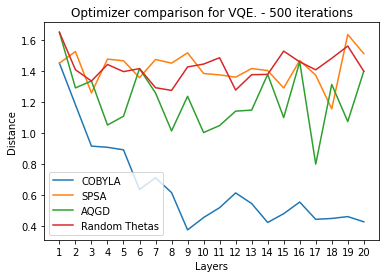

In [31]:
# Evaluating all optimizers

x_axis = list(range(1, L+1))
plt.xticks(x_axis)
plt.plot(x_axis, cobyla_results, label="COBYLA")
plt.plot(x_axis, spsa_results, label="SPSA")
plt.plot(x_axis, aqgd_results, label="AQGD")
plt.plot(x_axis, random_results, label="Random Thetas")
plt.title('Optimizer comparison for VQE. - '+ str(ITERATIONS) +" iterations")
plt.legend()
plt.xlabel('Layers')
plt.ylabel('Distance')
plt.savefig('Optimizer_Benchmark_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'_'+ODD_GATES_ROTATION+EVEN_GATES_ROTATION+EVEN_GATES_ENTANGLER+'.png')


## Quick time performance / Benchmark calculation
Because real time is also important!

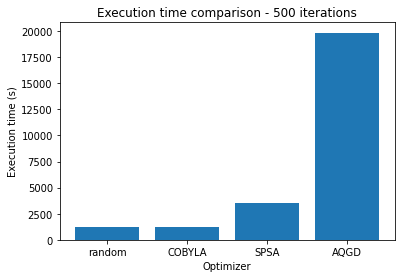

In [32]:
# Plot execution timmes performance
keys = CALCULATION_TIMES.keys()
values = CALCULATION_TIMES.values()

plt.xlabel('Optimizer')
plt.ylabel('Execution time (s)')
plt.title('Execution time comparison - '+ str(ITERATIONS) +" iterations")
plt.bar(keys, values)
plt.savefig('Execution_time_comparison_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'_'+ODD_GATES_ROTATION+EVEN_GATES_ROTATION+EVEN_GATES_ENTANGLER+'.png')

## Bonus question
Try using other gates for the parametrized gates and see what happens.

Luckily we have parametrized the variational circuit, so we can nicely compare the different options. We will focus on COBYLA only since it provided the best results.

Here we iterate and create permutations on both the odd and even blocks and store them in a dictionary. Feel free to change the permutations and run them several times, and then add them into the plot

As expected, the difference in the space exploration happens when we change the rotation on the even gates and odd gates, between RZ's, RX's and RY's. But the entangler blocks making no difference to the final approximation.

In [14]:
cobyla_variational_results = {}

In [15]:
## Trial with COBYLA
ODD_GATES_ROTATION = "RY"
EVEN_GATES_ROTATION = "RZ"
EVEN_GATES_ENTANGLER = "CX"

cobyla_variational_results["COBYLA_RY_RZ_CX"] = []
optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_variational_results["COBYLA_RY_RZ_CX"].append(ret[1])

Layers:  1 | Distance:  1.4918208642337947
Layers:  2 | Distance:  1.2168339764993779
Layers:  3 | Distance:  1.075950314080023
Layers:  4 | Distance:  0.7056365982135812
Layers:  5 | Distance:  0.7197548244283696
Layers:  6 | Distance:  0.6976173350538832
Layers:  7 | Distance:  0.6813049585053973
Layers:  8 | Distance:  0.5734454937386964
Layers:  9 | Distance:  0.4674655384177821
Layers:  10 | Distance:  0.4493451675008417


In [16]:
## Trial with COBYLA
ODD_GATES_ROTATION = "RY"
EVEN_GATES_ROTATION = "RY"
EVEN_GATES_ENTANGLER = "CX"

cobyla_variational_results["COBYLA_RY_RY_CX"] = []

optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_variational_results["COBYLA_RY_RY_CX"].append(ret[1])
    

Layers:  1 | Distance:  1.29679910949666
Layers:  2 | Distance:  0.9823984497484719
Layers:  3 | Distance:  1.1061936180277996
Layers:  4 | Distance:  1.1175470814222965
Layers:  5 | Distance:  1.1174090777542587
Layers:  6 | Distance:  0.9230312880196104
Layers:  7 | Distance:  0.80883956700704
Layers:  8 | Distance:  0.811102847948822
Layers:  9 | Distance:  0.8249122739311848
Layers:  10 | Distance:  0.8260190508874096


In [17]:
## Trial with COBYLA
ODD_GATES_ROTATION = "RY"
EVEN_GATES_ROTATION = "RX"
EVEN_GATES_ENTANGLER = "CX"

cobyla_variational_results["COBYLA_RY_RX_CX"] = []

optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_variational_results["COBYLA_RY_RX_CX"].append(ret[1])

Layers:  1 | Distance:  1.3550412908085916
Layers:  2 | Distance:  1.0770752999786208
Layers:  3 | Distance:  0.7978249868134263
Layers:  4 | Distance:  0.7634566327211614
Layers:  5 | Distance:  0.4989236058886853
Layers:  6 | Distance:  0.5095189848858741
Layers:  7 | Distance:  0.5564433402116156
Layers:  8 | Distance:  0.6518488504131211
Layers:  9 | Distance:  0.5067761986494979
Layers:  10 | Distance:  0.601880999004077


In [18]:
# Data for my eyes

for i in cobyla_variational_results:
    print(i)
    print(cobyla_variational_results[i])

COBYLA_RY_RZ_CX
[1.4918208642337947, 1.2168339764993779, 1.075950314080023, 0.7056365982135812, 0.7197548244283696, 0.6976173350538832, 0.6813049585053973, 0.5734454937386964, 0.4674655384177821, 0.4493451675008417]
COBYLA_RY_RY_CX
[1.29679910949666, 0.9823984497484719, 1.1061936180277996, 1.1175470814222965, 1.1174090777542587, 0.9230312880196104, 0.80883956700704, 0.811102847948822, 0.8249122739311848, 0.8260190508874096]
COBYLA_RY_RX_CX
[1.3550412908085916, 1.0770752999786208, 0.7978249868134263, 0.7634566327211614, 0.4989236058886853, 0.5095189848858741, 0.5564433402116156, 0.6518488504131211, 0.5067761986494979, 0.601880999004077]


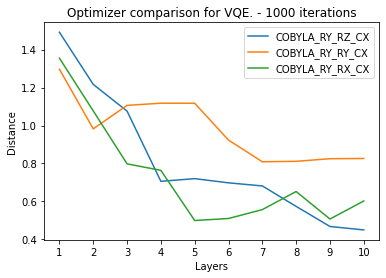

In [19]:
# Evaluating all optimizers

x_axis = list(range(1, L+1))
plt.xticks(x_axis)
for combination in cobyla_variational_results:
    plt.plot(x_axis, cobyla_variational_results[combination], label=combination)
plt.title('Optimizer comparison for VQE. - '+ str(ITERATIONS) +" iterations")
plt.legend()
plt.xlabel('Layers')
plt.ylabel('Distance')
plt.savefig('COBYLA_Benchmark_Gates_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'.png')


## Conclusions

After launching the experiments several times and with different iterations and hyperparameters we conclude that COBYLA provides the closest approximation to the initial random vector.

The chosen Ansatz could be potentially optimized, as well as fine tunning the parameters. In some cases we are overshooting and producing wrong results just because of the choice of said hyperparameters. Further exploration can be done to use different optimizers and evaluate their performance.

In general, we see that for most optimizers there is a threshold in the number of layers (3-4) after which more gates don't bring additional marginal benefit on the approximation. Results differ depending on the original vector and the initial random parameters but this threshold seems to hold for around 1000 iterations each.

* 400 Iterations
![400 Iterations RX RZ CZ](Optimizer_Benchmark_1599648012.2742789_Iterations_400_RXRZCZ.png)

* 1000 Iterations
 ![1000 Iterations RX RZ CZ](Optimizer_Benchmark_1599729182.458417_Iterations_1000_RXRZCZ.png)
 
 * For 1000 Iterations there is a big difference in execution time (run on a Macbook Pro and the Aer simulator)
 ![!Performance](Execution_time_comparison_1599729182.980351_Iterations_1000_RXRZCZ.png)

It is interesting to note from the variation of rotations, that the best combination for the COBYLA is when we apply RY and RZ rotations and CX entangler. One potential reason could be that with the three rotations we can explore the hamiltonian space completely.

* 400 Iterations switching gates for COBYLA
![](COBYLA_Benchmark_Gates_1599649105.65573_Iterations_400.png)

* 1000 Iterations switching gates for COBYLA
![](COBYLA_Benchmark_Gates_1599680684.540425_Iterations_1000.png)

* Another 1000 Iterations round switching gates for COBYLA. As expected, RY-RX and RY-RZ tend to converge. Whereas the RY-RY-CX can't converge as well
![](COBYLA_Benchmark_Gates_1599731458.607714_Iterations_1000.png)

* Based on the potential optimal ansatz based on the desired Odd and Even unitary gates, we have launched the combination to compare with SPSA and Montecarlo, but find no relevant difference respect the previous results
![](Optimizer_Benchmark_1599737378.129796_Iterations_1000_RYRZCX.png)

* For a last test we run a 500 Iterations simulation on 20 Layers to evaluate whether additional gates (and therefore more Thetas to opimize) produce any relevant result. It took some time on my humble machine, and the depth of the circuit was interesting. But even with that we don't see any special improvement on the data
![](Optimizer_Benchmark_1599764422.732799_Iterations_500_RXRZCZ.png)



## Sources
- SPSA Qiskit documentation: https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.SPSA.html#qiskit.aqua.components.optimizers.SPSA
- AGQD Quiskit Documentation: https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.AQGD.html#qiskit.aqua.components.optimizers.AQGD
- Scipy Documentation for Minimize: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
- VQE Tutorial by Davit Khatch: https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb